In [1]:
import numpy as np
import torch
from itertools import product
from scipy import stats

In [2]:
# Linear regression
num_samples = 100       # per group (total = num_samples * num_groups)
num_features = 700
num_groups = 3

np.random.seed(42)
noise_level = 0.1
true_beta = np.random.randn( num_features, 1 ) # does not include the identifier weight.

In [3]:
def fully_structured_covariance(d):
    return np.diag( np.random.uniform(0.3, 4, size = d) ** 2 )

def identity_covariance(d):
    return np.identity( d )

class Group:

    ID = 0

    def __init__(self, covariance_generator = lambda: identity_covariance(num_features) ):
        self.id = Group.ID + 1
        Group.ID += 1

        self.cov = covariance_generator()
        self.x_dist = stats.multivariate_normal( cov = self.cov )

        self.x = None
        self.y = None
    
    # Generates X (input vars) 
    def _generate_x(self, n_samples, ID = False , **kwargs):
        x = self.x_dist.rvs(size= n_samples, **kwargs)
        if ID:
            identifier = np.repeat( self.ID , repeats=n_samples)
            x = np.column_stack( (identifier, x))
        return x
    
    # Generates (X, y) pairs according to linear model
    def generate(self, n_samples, beta = true_beta):
        x = self._generate_x(n_samples)
        y = np.dot(x, beta) + noise_level * np.random.randn(n_samples, 1)
        self.data = [x, y]
    
    @property
    def data(self):
        return self.x, self.y
    
    @data.setter
    def data(self, value):
        x, y = value # unpack
        self.x = torch.tensor(x, dtype = torch.float32, requires_grad=False)
        self.y = torch.tensor(y, dtype = torch.float32, requires_grad=False)

# Create the data
cov_generator = lambda: fully_structured_covariance(num_features)
groups = [ Group(cov_generator) for _ in range(num_groups) ]

# TODO: by this data generating process, we have equal number of groups in the
# training data, all disjoint. should we change this up (vary # of samples/gp)?
Data = {}
for group in groups:
    group.generate(num_samples, beta=true_beta)

X = torch.cat( [ group.x for group in groups ], dim = 0 )
Y = torch.cat( [ group.y for group in groups ], dim = 0 )

In [11]:

class LinearModel(torch.nn.Module):

    def __init__(self, input_dimension, **kwargs) -> None:
        super(LinearModel, self).__init__()
        # Initialize at zero. 
        self.linear = torch.nn.Linear( input_dimension, 1, bias = False, **kwargs )
        self._initialize(0.0)
    
    @torch.no_grad()
    def _initialize(self, value):
        self.linear.weight.fill_(value)
        if self.linear.weight.grad is not None:
            self.linear.weight.grad.detach_()
            self.linear.weight.grad.zero_()
    
    # forward passes should NOT come from calling this directly!
    # i.e. model(x) instead of model.forward(x)
    def forward(self, x):
        out = self.linear(x)
        return out
    
    # by default, MSELoss divides by n, the size of sample
    def risk(self, x, y):
        loss = torch.nn.MSELoss()
        mse = loss( self(x) , y )
        return mse
    
# training loop (gradient descent on the balanaced risk: lmbd * std + dro)
def optimize_GD(model, X, Y, groups, trade_regularization = 0.1, beta_regularization = 0, max_iter = 5000, lr = 1e-3, weight_decay = 0.0):
    lmbd = torch.tensor([trade_regularization], requires_grad=False)
    eta = torch.tensor([beta_regularization], requires_grad=False)  # explicit regularizer for beta
    optimizer = torch.optim.SGD( params = model.parameters(), lr = lr, weight_decay = weight_decay )

    flag = True         # for convergence criterion (objective low enough)
    iteration = 0
    while flag and iteration < max_iter:
        optimizer.zero_grad()

        standard_risk = model.risk( X, Y )
        adversarial_risk = torch.max( torch.stack( [ model.risk(group.x, group.y) for group in groups ] ) )
        objective = lmbd * standard_risk + (1-lmbd) * adversarial_risk + eta * torch.norm(model.linear.weight)

        objective.backward()
        optimizer.step()

        if iteration % 100 == 0:
            print(f" Objective loss is {objective.item():.4f}  = {lmbd.item():.2f} * { standard_risk.item():.4f} + {adversarial_risk.item():.4f}")
        iteration += 1

        # Check convergence
        if objective.item() < 1e-4:
            flag = False
    
    if iteration == max_iter:
        print("Maximum iteration reached.")

In [13]:
# Solve the weighted regression problem using vanilla GD
lmbd = torch.tensor([0.1], requires_grad=False)
max_iter = 2000

model = LinearModel(num_features)
optimize_GD(model, X, Y, groups, trade_regularization = 0.5, max_iter= max_iter)

 Objective loss is 4463.4160  = 0.50 * 4238.8760 + 4687.9561
 Objective loss is 77.8093  = 0.50 * 77.0408 + 78.5778
 Objective loss is 17.4213  = 0.50 * 17.1281 + 17.7145
 Objective loss is 5.9211  = 0.50 * 5.8256 + 6.0167
 Objective loss is 2.4168  = 0.50 * 2.3901 + 2.4435
 Objective loss is 1.0849  = 0.50 * 1.0723 + 1.0975
 Objective loss is 0.5129  = 0.50 * 0.5094 + 0.5164
 Objective loss is 0.2522  = 0.50 * 0.2507 + 0.2537
 Objective loss is 0.1275  = 0.50 * 0.1264 + 0.1286
 Objective loss is 0.0657  = 0.50 * 0.0649 + 0.0664
 Objective loss is 0.0344  = 0.50 * 0.0338 + 0.0350
 Objective loss is 0.0178  = 0.50 * 0.0177 + 0.0179
 Objective loss is 0.0096  = 0.50 * 0.0094 + 0.0097
 Objective loss is 0.0051  = 0.50 * 0.0050 + 0.0051
 Objective loss is 0.0027  = 0.50 * 0.0027 + 0.0027
 Objective loss is 0.0015  = 0.50 * 0.0015 + 0.0015
 Objective loss is 0.0008  = 0.50 * 0.0008 + 0.0008
 Objective loss is 0.0004  = 0.50 * 0.0004 + 0.0004
 Objective loss is 0.0002  = 0.50 * 0.0002 + 0.00

In [14]:
# OLS
ols_beta = torch.linalg.lstsq( X, Y ).solution

# Subgroups- OLS
subgroup_beta = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ]

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

betas = np.hstack( [model.linear.weight.data.numpy().T, ols_beta.data.numpy()] + [beta.data.numpy() for beta in subgroup_beta ] )
betas = pd.DataFrame( betas, columns=["model", "OLS"] + [f"Group {i} OLS" for i in range(num_groups)] )

In [16]:
betas.corr()

,model,OLS,Group 0 OLS,Group 1 OLS,Group 2 OLS
model,1.000000,1.000000,0.568328,0.572141,0.613573
OLS,1.000000,1.000000,0.568303,0.572074,0.613536
Group 0 OLS,0.568328,0.568303,1.000000,0.145211,0.120815
Group 1 OLS,0.572141,0.572074,0.145211,1.000000,0.204174
Group 2 OLS,0.613573,0.613536,0.120815,0.204174,1.000000


## Experiment 1: Varying $\lambda$ Tradeoff Parameter
Our notion of tradeoff risk between DRO and standard risk is controlled by the parameter $\lambda$. Fully writing out the
tradeoff objective, we have:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda) := \mathcal{R}_{\mathrm{group}}(\beta) + \lambda \mathcal{R}_{\mathrm{std}}(\beta)
= \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \lambda \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right],
$$
where $\mathbb{P}_g$ is the group distribution for group $g \in \mathcal{G}$. The $\lambda$ parameter controls how much we tradeoff for standard risk in our objective. $\lambda = 0$ means we are solely optimizing for group DRO. We vary the value of $\lambda$ and see if this has any effect on the resulting $\hat{\beta}$ that our model produces by minimizing $\hat{\mathcal{R}}_{\mathrm{trade}}$


In [17]:
import matplotlib.pyplot as plt

max_iter = 2000
lambdas = torch.tensor(np.linspace(0, 1.0), requires_grad=False)
ols_beta = torch.linalg.lstsq( X, Y ).solution  # regular OLS solution
subgroup_betas = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ] # OLS for each group
model_betas = list()

for lmbd in lambdas:
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, X, Y, groups, trade_regularization = lmbd, max_iter= max_iter)
    model_betas.append(model.linear.weight.data.numpy().T)

 Objective loss is 4687.9561  = 0.00 * 4238.8760 + 4687.9561
 Objective loss is 77.6959  = 0.00 * 74.4841 + 77.6959
 Objective loss is 17.3530  = 0.00 * 16.4304 + 17.3530
 Objective loss is 5.9559  = 0.00 * 5.5519 + 5.9559
 Objective loss is 2.3217  = 0.00 * 2.2561 + 2.3217
 Objective loss is 1.0463  = 0.00 * 1.0091 + 1.0463
 Objective loss is 0.4993  = 0.00 * 0.4723 + 0.4993
 Objective loss is 0.2500  = 0.00 * 0.2309 + 0.2500
 Objective loss is 0.1230  = 0.00 * 0.1152 + 0.1230
 Objective loss is 0.0607  = 0.00 * 0.0587 + 0.0607
 Objective loss is 0.0314  = 0.00 * 0.0303 + 0.0314
 Objective loss is 0.0169  = 0.00 * 0.0158 + 0.0169
 Objective loss is 0.0087  = 0.00 * 0.0083 + 0.0087
 Objective loss is 0.0045  = 0.00 * 0.0044 + 0.0045
 Objective loss is 0.0024  = 0.00 * 0.0023 + 0.0024
 Objective loss is 0.0013  = 0.00 * 0.0013 + 0.0013
 Objective loss is 0.0007  = 0.00 * 0.0007 + 0.0007
 Objective loss is 0.0004  = 0.00 * 0.0004 + 0.0004
 Objective loss is 0.0002  = 0.00 * 0.0002 + 0.00

Text(0.5, 1.0, 'Effect of $\\lambda$ in Tradeoff Objective')

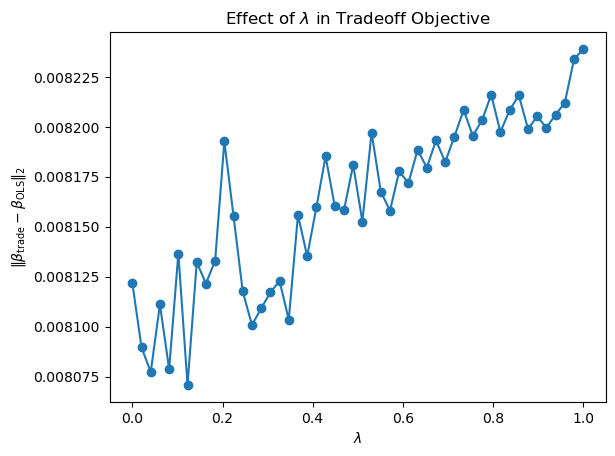

In [18]:
# Plot difference between model's betas and OLS beta
# Is this actually a significant difference?
beta_l2 = [np.linalg.norm(model_beta - ols_beta.numpy()) for model_beta in model_betas]
plt.plot(lambdas, beta_l2, marker='o')
plt.xlabel(r"$\lambda$")
plt.ylabel(r'$\| \beta_{\mathrm{trade}} - \beta_{\mathrm{OLS}} \|_2$')
plt.title(r"Effect of $\lambda$ in Tradeoff Objective")

Text(0.5, 1.0, 'Effect of $\\lambda$ in Tradeoff Objective')

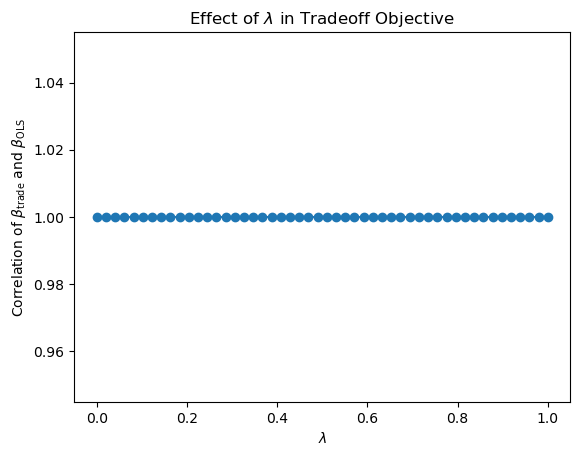

In [19]:
# Plot correlations between tradeoff model betas and OLS beta
corr_betas = np.array([np.corrcoef(model_beta.flatten(), ols_beta.numpy().flatten())[0, 1] for model_beta in model_betas])
corr_betas = np.around(corr_betas, decimals=5)
plt.plot(lambdas, corr_betas, marker='o')
plt.xlabel(r"$\lambda$")
plt.ylabel(r'Correlation of $\beta_{\mathrm{trade}}$ and $\beta_{\mathrm{OLS}}$')
plt.title(r"Effect of $\lambda$ in Tradeoff Objective")

Upshot: **they're the same!**

## Experiment 2: Adding Explicit Regularizer ($\eta\|\beta\|^2$) for different $\lambda$
Now, we add an explicit $\ell_2$ regularization to the objective, controlled by $\eta > 0.$ This gives us the objective:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda; \eta)
= (1 - \lambda) \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \lambda \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right] + \eta\|\beta\|_2,
$$
where we vary $\lambda \in [0, 1]$. Again, we denote the $\beta$ that we get from running GD on $\mathcal{R}_{\mathrm{trade}}(\beta; \lambda)$ as $\beta_{\mathrm{trade}}$. We denote the OLS solution as $\beta_{\mathrm{OLS}}$. For $\lambda = 1$, the $\mathcal{R}_{\mathrm{trade}}$ objective is equivalent to ridge regression, which we also compare to for the same values of $\eta$.

In [24]:
import torch.nn.functional as F

# Ridge Regression
class Ridge:
    def __init__(self, eta = 0, fit_intercept = True,):
        self.eta = eta
        self.fit_intercept = fit_intercept
        
    def fit(self, X: torch.tensor, y: torch.tensor) -> None:
        X = X.rename(None)
        y = y.rename(None).view(-1,1)
        assert X.shape[0] == y.shape[0], "Number of X and y rows don't match"
        if self.fit_intercept:
            X = torch.cat([torch.ones(X.shape[0], 1), X], dim = 1)
        # Solving X*w = y with Normal equations:
        # X^{T}*X*w = X^{T}*y 
        lhs = X.T @ X 
        rhs = X.T @ y
        if self.eta == 0:
            self.w = torch.linalg.lstsq(rhs, lhs).solution
        else:
            ridge = self.eta*torch.eye(lhs.shape[0])
            self.w = torch.linalg.lstsq(rhs, lhs + ridge).solution
            
    def predict(self, X: torch.tensor) -> None:
        X = X.rename(None)
        if self.fit_intercept:
            X = torch.cat([torch.ones(X.shape[0], 1), X], dim = 1)
        return X @ self.w

In [51]:
import matplotlib.pyplot as plt

max_iter = 2000
ols_beta = torch.linalg.lstsq( X, Y ).solution  # regular OLS solution
subgroup_ols_betas = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ] # OLS for each group

# For each value of lambda, experiment with beta regularizer (vary values of eta)
model_betas = {}        # key: lambda, value: a list of betas for that fixed lambda, varying eta
etas = torch.tensor([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5], requires_grad=False)
lambdas = torch.tensor(np.linspace(0, 1.0, num=11), requires_grad=False)
for lmbd in lambdas:
    # train tradeoff model for different values of eta
    model_betas[lmbd.item()] = []
    for eta in etas:
        # Tradeoff Objective
        model = LinearModel(num_features)
        optimize_GD(model, X, Y, groups, trade_regularization =lmbd, beta_regularization=eta, max_iter=max_iter)
        model_betas[lmbd.item()].append(model.linear.weight.data.numpy().T)

ridge_betas = []
for eta in etas:
    # Ridge Regression
    ridge_model = Ridge(eta=eta.item(), fit_intercept=False)
    ridge_model.fit(X, Y)
    ridge_beta = ridge_model.w
    ridge_betas.append(ridge_beta)

 Objective loss is 4687.9561  = 0.00 * 4238.8760 + 4687.9561
 Objective loss is 77.6961  = 0.00 * 74.4841 + 77.6960
 Objective loss is 17.3532  = 0.00 * 16.4304 + 17.3530
 Objective loss is 5.9561  = 0.00 * 5.5519 + 5.9559
 Objective loss is 2.3218  = 0.00 * 2.2561 + 2.3217
 Objective loss is 1.0464  = 0.00 * 1.0091 + 1.0463
 Objective loss is 0.4994  = 0.00 * 0.4723 + 0.4993
 Objective loss is 0.2502  = 0.00 * 0.2309 + 0.2500
 Objective loss is 0.1232  = 0.00 * 0.1152 + 0.1230
 Objective loss is 0.0609  = 0.00 * 0.0587 + 0.0607
 Objective loss is 0.0316  = 0.00 * 0.0303 + 0.0314
 Objective loss is 0.0171  = 0.00 * 0.0158 + 0.0169
 Objective loss is 0.0089  = 0.00 * 0.0083 + 0.0087
 Objective loss is 0.0047  = 0.00 * 0.0044 + 0.0045
 Objective loss is 0.0025  = 0.00 * 0.0023 + 0.0024
 Objective loss is 0.0015  = 0.00 * 0.0013 + 0.0013
 Objective loss is 0.0009  = 0.00 * 0.0007 + 0.0007
 Objective loss is 0.0006  = 0.00 * 0.0004 + 0.0004
 Objective loss is 0.0004  = 0.00 * 0.0002 + 0.00

Text(0.5, 1.0, 'Effect of $\\eta$ Regularization for Average Accuracy OLS')

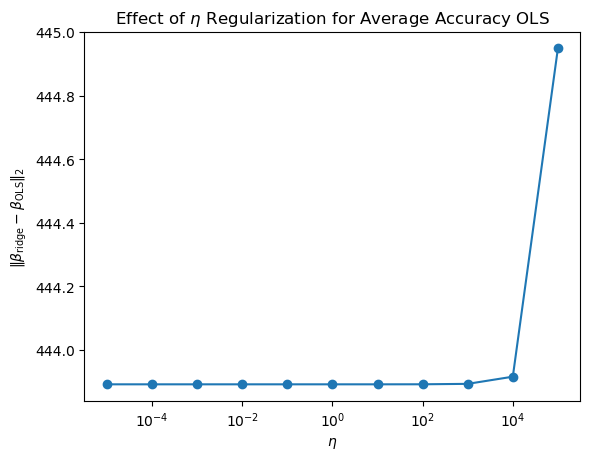

In [52]:
ridge_beta_l2 = [np.linalg.norm(ridge_beta - ols_beta.numpy()) for ridge_beta in ridge_betas]
plt.plot(etas, ridge_beta_l2, marker='o')
plt.xscale('log')
plt.xlabel(r"$\eta$")
plt.ylabel(r'$\| \beta_{\mathrm{ridge}} - \beta_{\mathrm{OLS}} \|_2$')
plt.title(r"Effect of $\eta$ Regularization for Average Accuracy OLS")
plt.show()

Text(0.5, 1.0, 'Effect of $\\eta$ Regularization for $\\lambda=0$ (Group DRO)')

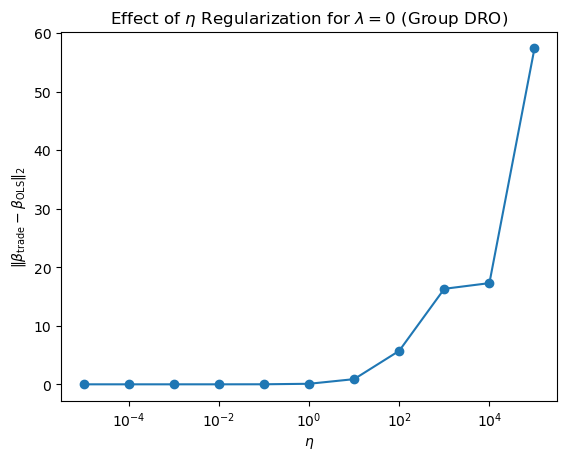

In [53]:
model_beta_l2 = [np.linalg.norm(model_beta - ols_beta.numpy()) for model_beta in model_betas[0]]
plt.plot(etas, model_beta_l2, marker='o')
plt.xscale('log')
plt.xlabel(r"$\eta$")
plt.ylabel(r'$\| \beta_{\mathrm{trade}} - \beta_{\mathrm{OLS}} \|_2$')
plt.title(r"Effect of $\eta$ Regularization for $\lambda=0$ (Group DRO)")
plt.show()

Text(0.5, 1.0, 'Effect of $\\eta$ Regularization for $\\lambda=0$ (Group DRO)')

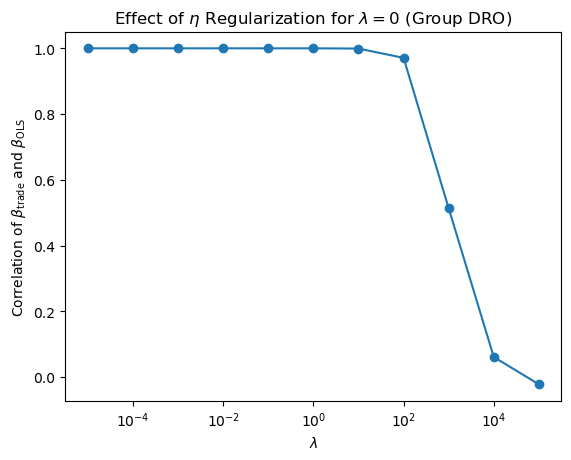

In [54]:
corr_betas = np.array([np.corrcoef(model_beta.flatten(), ols_beta.numpy().flatten())[0, 1] for model_beta in model_betas[0]])
corr_betas = np.around(corr_betas, decimals=5)
plt.plot(etas, corr_betas, marker='o')
plt.xscale('log')
plt.xlabel(r"$\lambda$")
plt.ylabel(r'Correlation of $\beta_{\mathrm{trade}}$ and $\beta_{\mathrm{OLS}}$')
plt.title(r"Effect of $\eta$ Regularization for $\lambda=0$ (Group DRO)")
plt.show()

In [68]:
# Evaluate on a test set
cov_generator = lambda: fully_structured_covariance(num_features)
groups_test = [ Group(cov_generator) for _ in range(num_groups) ]

for group in groups_test:
    group.generate(num_samples, beta=true_beta)

X_test = torch.cat( [ group.x for group in groups_test ], dim = 0 )
Y_test = torch.cat( [ group.y for group in groups_test ], dim = 0 )

In [100]:
# Comparison to of Test vs. Train Loss
loss = torch.nn.MSELoss()
def worst_gp_MSE(beta, groups):
    loss = torch.nn.MSELoss()
    worst_gp_err = torch.max( torch.stack( [ loss(group.x@beta, group.y) for group in groups ] ) )
    return worst_gp_err

ols_worstgp_train_err = worst_gp_MSE(ols_beta, groups).item()
ols_worstgp_test_err = worst_gp_MSE(ols_beta, groups_test).item()
print("Worst-group train error of OLS Beta: {}".format(ols_worstgp_train_err))
print("Worst-group test error of OLS Beta: {}".format(ols_worstgp_test_err))

ols_train_err = loss(X@ols_beta, Y).item()
ols_test_err = loss(X_test@ols_beta, Y_test).item()
print("Train error of OLS Beta: {}".format(ols_train_err))
print("Test error of OLS Beta: {}".format(ols_test_err))

Worst-group train error of OLS Beta: 2.140207122636184e-09
Worst-group test error of OLS Beta: 2822.409912109375
Train error of OLS Beta: 1.824597362087843e-09
Test error of OLS Beta: 2309.1572265625


In [101]:
model_errs = {}
for lmbd in lambdas:
    model_errs[lmbd.item()] = {}
    model_errs[lmbd.item()]['train_errs'] = []
    model_errs[lmbd.item()]['test_errs'] = []
    model_errs[lmbd.item()]['worstgp_train_errs'] = []
    model_errs[lmbd.item()]['worstgp_test_errs'] = []
    for i, model_beta in enumerate(model_betas[lmbd.item()]):
        train_err = loss(X@model_beta, Y).item()
        test_err = loss(X_test@model_beta, Y_test).item()
        worstgp_train_err = worst_gp_MSE(model_beta, groups).item()
        worstgp_test_err = worst_gp_MSE(model_beta, groups_test).item()

        print("Worst-group train error of Group DRO Beta: {}".format(worstgp_train_err))
        model_errs[lmbd.item()]['worstgp_train_errs'].append(worstgp_train_err)
        print("Worst-group test error of Group DRO Beta: {}".format(worstgp_test_err))
        model_errs[lmbd.item()]['worstgp_test_errs'].append(worstgp_test_err)

        print("Train error of Group DRO Beta (eta={}): {}".format(etas[i], train_err))
        model_errs[lmbd.item()]['train_errs'].append(train_err)
        print("Test error of Group DRO Beta (eta = {}): {}".format(etas[i], test_err))
        model_errs[lmbd.item()]['test_errs'].append(test_err)

Worst-group train error of Group DRO Beta: 5.956982204224914e-05
Worst-group test error of Group DRO Beta: 2822.402587890625
Train error of Group DRO Beta (eta=9.999999747378752e-06): 5.909442188567482e-05
Test error of Group DRO Beta (eta = 9.999999747378752e-06): 2309.19189453125
Worst-group train error of Group DRO Beta: 5.960698763374239e-05
Worst-group test error of Group DRO Beta: 2822.403076171875
Train error of Group DRO Beta (eta=9.999999747378752e-05): 5.917440648772754e-05
Test error of Group DRO Beta (eta = 9.999999747378752e-05): 2309.19189453125
Worst-group train error of Group DRO Beta: 6.197099719429389e-05
Worst-group test error of Group DRO Beta: 2822.40185546875
Train error of Group DRO Beta (eta=0.0010000000474974513): 6.009327989886515e-05
Test error of Group DRO Beta (eta = 0.0010000000474974513): 2309.189697265625
Worst-group train error of Group DRO Beta: 7.520287908846512e-05
Worst-group test error of Group DRO Beta: 2822.386962890625
Train error of Group DRO B

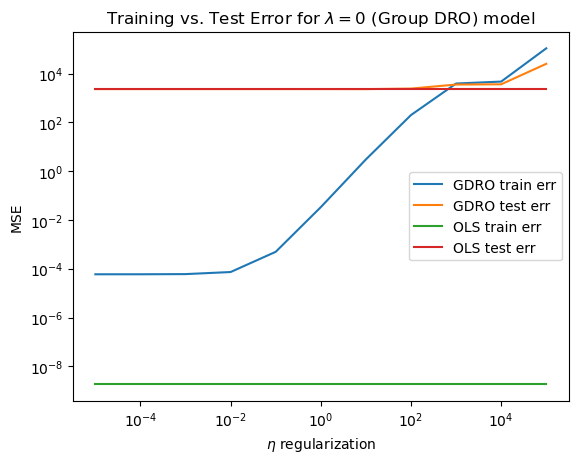

In [102]:
# Plot train vs. test for Group DRO (lambda=0)
fig, ax = plt.subplots()
ax.plot(etas, model_errs[0]['train_errs'], label='GDRO train err')
ax.plot(etas, model_errs[0]['test_errs'], label="GDRO test err")
ax.plot(etas, [ols_train_err for _ in range(len(etas))], label='OLS train err')
ax.plot(etas, [ols_test_err for _ in range(len(etas))], label='OLS test err')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(r"Training vs. Test Error for $\lambda=0$ (Group DRO) model")
ax.set_xlabel(r"$\eta$ regularization")
ax.set_ylabel(r"MSE")
ax.legend()

plt.show()


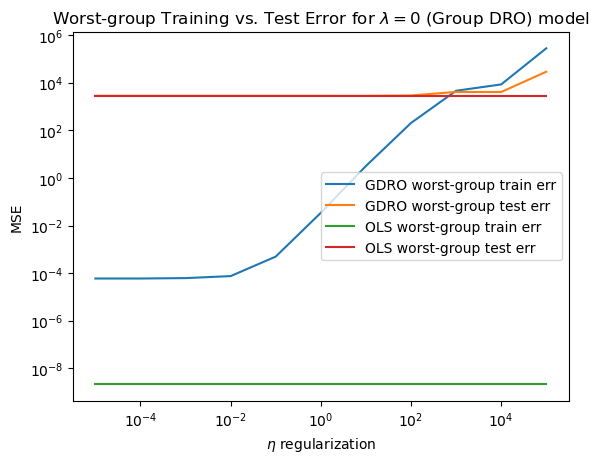

In [103]:
# Plot worst-group train vs. test for Group DRO (lambda=0)
fig, ax = plt.subplots()
ax.plot(etas, model_errs[0]['worstgp_train_errs'], label='GDRO worst-group train err')
ax.plot(etas, model_errs[0]['worstgp_test_errs'], label="GDRO worst-group test err")
ax.plot(etas, [ols_worstgp_train_err for _ in range(len(etas))], label='OLS worst-group train err')
ax.plot(etas, [ols_worstgp_test_err for _ in range(len(etas))], label='OLS worst-group test err')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(r"Worst-group Training vs. Test Error for $\lambda=0$ (Group DRO) model")
ax.set_xlabel(r"$\eta$ regularization")
ax.set_ylabel(r"MSE")
ax.legend()

plt.show()